In [23]:
import pennylane as qml
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
# Load and prepare data
digits = load_digits(n_class=2)  # Just use 0 and 1 for simplicity
X = digits.data / 16.0  # Normalize pixel values
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

In [26]:
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    # Encode the inputs
    for i in range(num_qubits):
        qml.RY(inputs[i], wires=i)
    
    # Apply trainable rotation gates
    for i in range(num_qubits):
        qml.RZ(weights[0, i], wires=i)
        qml.RY(weights[1, i], wires=i)
    
    # Entangle qubits
    for i in range(num_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    
    # Apply more trainable gates
    for i in range(num_qubits):
        qml.RZ(weights[2, i], wires=i)
        qml.RY(weights[3, i], wires=i)
    
    # Measure the first qubit
    return qml.expval(qml.PauliZ(0))

In [27]:
def hybrid_model(inputs, weights):
    # Dimension reduction (take the first 4 components for our 4 qubits)
    inputs_subset = inputs[:4]
    return quantum_circuit(inputs_subset, weights)

In [28]:
def cost(weights, X, y):
    predictions = [hybrid_model(x, weights) for x in X]
    return np.mean((predictions - y) ** 2)

In [29]:
np.random.seed(42)
weights = np.random.randn(4, num_qubits)

In [30]:
train_subset = 20
X_train_subset = X_train[:train_subset]
y_train_subset = y_train[:train_subset]


In [31]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
steps = 20

for i in range(steps):
    weights = opt.step(lambda w: cost(w, X_train_subset, y_train_subset), weights)
    if (i + 1) % 5 == 0:
        cost_val = cost(weights, X_train_subset, y_train_subset)
        print(f"Step {i+1}, Cost: {cost_val:.4f}")

Step 5, Cost: 0.3941
Step 10, Cost: 0.3941
Step 15, Cost: 0.3941
Step 20, Cost: 0.3941


In [32]:
test_subset = 10
X_test_subset = X_test[:test_subset]
y_test_subset = y_test[:test_subset]

predictions = [hybrid_model(x, weights) for x in X_test_subset]
binary_predictions = [1 if p > 0 else 0 for p in predictions]

accuracy = np.mean(binary_predictions == y_test_subset)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.5000


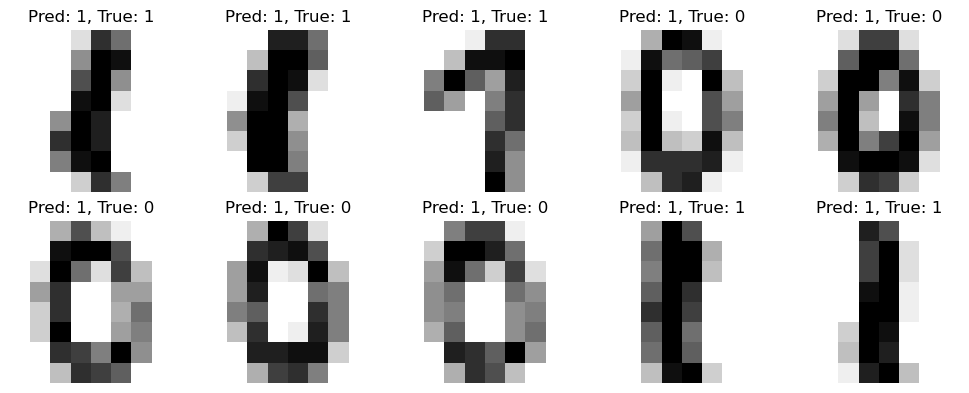

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < len(X_test_subset):
        ax.imshow(X_test_subset[i].reshape(8, 8), cmap='binary')
        pred = binary_predictions[i]
        actual = y_test_subset[i]
        ax.set_title(f"Pred: {pred}, True: {actual}")
    ax.axis('off')
plt.tight_layout()
plt.show()